# Test FastAPI Server

This notebook tests all API endpoints of the Sydney Housing Data API.


In [1]:
import requests
import json
import pandas as pd
from typing import Dict, Any

# API base URL
BASE_URL = "http://localhost:8000"

print(f"Testing API at {BASE_URL}")
print("="*80)


Testing API at http://localhost:8000


In [2]:
# Helper function to make requests
def test_endpoint(method: str, endpoint: str, params: Dict[str, Any] = None, data: Dict = None):
    """Test an API endpoint and return response."""
    url = f"{BASE_URL}{endpoint}"
    print(f"\n{method} {endpoint}")
    if params:
        print(f"  Params: {params}")
    
    try:
        if method == "GET":
            response = requests.get(url, params=params)
        elif method == "POST":
            response = requests.post(url, json=data)
        else:
            raise ValueError(f"Unsupported method: {method}")
        
        print(f"  Status: {response.status_code}")
        
        if response.status_code == 200:
            result = response.json()
            if isinstance(result, dict):
                if "items" in result:
                    print(f"   Returned {len(result['items'])} items (total: {result.get('total', 'N/A')})")
                elif "suburbs" in result:
                    print(f"   Found {len(result['suburbs'])} suburbs (total: {result.get('total', 'N/A')})")
                else:
                    print(f"   OK")
            elif isinstance(result, list):
                print(f"   Returned {len(result)} items")
            else:
                print(f"   OK")
            return result
        else:
            print(f"   Error: {response.text}")
            return None
    except requests.exceptions.ConnectionError:
        print(f"   Connection Error: Is the server running?")
        print(f"    Start server with: uvicorn src.main:app --reload")
        return None
    except Exception as e:
        print(f"   Error: {e}")
        return None

print("Helper function defined")


Helper function defined


In [3]:
# Test 1: Health check
print("="*80)
print("TEST 1: Health Check")
print("="*80)
health = test_endpoint("GET", "/health")


TEST 1: Health Check

GET /health
  Status: 200
   OK


In [4]:
# Test 2: Root endpoint
print("="*80)
print("TEST 2: Root Endpoint")
print("="*80)
root = test_endpoint("GET", "/")
if root:
    print(f"\nAPI Info:")
    print(json.dumps(root, indent=2))


TEST 2: Root Endpoint

GET /
  Status: 200
   OK

API Info:
{
  "name": "Sydney Housing Data API",
  "version": "1.0.0",
  "description": "API for querying Sydney property sales data",
  "endpoints": {
    "properties": "/api/properties",
    "analytics": "/api/analytics",
    "quarterly": "/api/quarterly",
    "docs": "/docs",
    "health": "/health"
  }
}


In [5]:
# Test 3: Properties endpoints
print("="*80)
print("TEST 3: Properties Endpoints")
print("="*80)

# List properties (first 10)
print("\n3.1 List properties (limit=10)")
props = test_endpoint("GET", "/api/properties", {"limit": 10})
if props and props.get("items"):
    print(f"\nSample property:")
    print(json.dumps(props["items"][0], indent=2, default=str))

# Filter by suburb
print("\n3.2 Filter by suburb (NEWTOWN)")
props_suburb = test_endpoint("GET", "/api/properties", {"suburb": "NEWTOWN", "limit": 5})
if props_suburb:
    print(f"Found {props_suburb.get('total', 0)} properties in NEWTOWN")

# Filter by property type
print("\n3.3 Filter by property type (house)")
props_type = test_endpoint("GET", "/api/properties", {"property_type": "house", "limit": 5})
if props_type:
    print(f"Found {props_type.get('total', 0)} houses")

# Get single property
if props and props.get("items"):
    prop_id = props["items"][0]["id"]
    print(f"\n3.4 Get property by ID ({prop_id})")
    prop = test_endpoint("GET", f"/api/properties/{prop_id}")
    if prop:
        print(f"Property: {prop['suburb']} - ${prop['sale_price']:,.0f}")

# Property stats
print("\n3.5 Property statistics")
stats = test_endpoint("GET", "/api/properties/stats/summary")
if stats:
    print(f"Total properties: {stats.get('total_count', 0):,}")
    print(f"Average price: ${stats.get('avg_price', 0):,.0f}")
    print(f"Median price: ${stats.get('median_price', 0):,.0f}")


TEST 3: Properties Endpoints

3.1 List properties (limit=10)

GET /api/properties
  Params: {'limit': 10}
  Status: 200
   Returned 10 items (total: 1953456)

Sample property:
{
  "suburb": "AUBURN",
  "postcode": "2144",
  "district": "261",
  "property_type": "unit",
  "contract_date": "2025-11-21",
  "settlement_date": "2025-12-24",
  "sale_price": 435000.0,
  "contract_to_settlement_days": 33,
  "id": 1953456,
  "listing_date": null,
  "days_on_market": null,
  "created_at": "2025-12-31T00:42:42"
}

3.2 Filter by suburb (NEWTOWN)

GET /api/properties
  Params: {'suburb': 'NEWTOWN', 'limit': 5}
  Status: 200
   Returned 5 items (total: 6972)
Found 6972 properties in NEWTOWN

3.3 Filter by property type (house)

GET /api/properties
  Params: {'property_type': 'house', 'limit': 5}
  Status: 200
   Returned 5 items (total: 880568)
Found 880568 houses

3.4 Get property by ID (1953456)

GET /api/properties/1953456
  Status: 200
   OK
Property: AUBURN - $435,000

3.5 Property statistics



In [6]:
# Test 4: Analytics endpoints
print("="*80)
print("TEST 4: Analytics Endpoints")
print("="*80)

# List analytics
print("\n4.1 List analytics (limit=10)")
analytics_list = test_endpoint("GET", "/api/analytics", {"limit": 10})
if analytics_list and analytics_list.get("items"):
    print(f"\nSample analytics:")
    sample = analytics_list["items"][0]
    print(f"  Suburb: {sample['suburb']}")
    print(f"  Property Type: {sample['property_type']}")
    print(f"  Current Median Price: ${sample.get('current_median_price', 0):,.0f}")
    print(f"  1yr Growth: {sample.get('growth_1yr_percentage', 0):.2f}%")

# Get analytics for specific suburb
print("\n4.2 Get analytics for NEWTOWN")
newtown_analytics = test_endpoint("GET", "/api/analytics/NEWTOWN")
if newtown_analytics:
    for analytics in newtown_analytics:
        print(f"\n{analytics['property_type'].upper()}:")
        print(f"  Current Median: ${analytics.get('current_median_price', 0):,.0f}")
        print(f"  Sales (Last 12m): {analytics.get('current_num_sales', 0)}")
        print(f"  1yr Growth: {analytics.get('growth_1yr_percentage', 0):.2f}%")

# Search suburbs
print("\n4.3 Search suburbs (query='NEW')")
suburb_search = test_endpoint("GET", "/api/analytics/search/suburbs", {"q": "NEW", "limit": 10})
if suburb_search:
    print(f"Found suburbs: {suburb_search.get('suburbs', [])}")


TEST 4: Analytics Endpoints

4.1 List analytics (limit=10)

GET /api/analytics
  Params: {'limit': 10}
  Status: 200
   Returned 10 items (total: 1159)

Sample analytics:
  Suburb: ABBOTSBURY
  Property Type: house
  Current Median Price: $1,727,500
  1yr Growth: 15.94%

4.2 Get analytics for NEWTOWN

GET /api/analytics/NEWTOWN
  Status: 200
   Returned 2 items

HOUSE:
  Current Median: $1,920,000
  Sales (Last 12m): 205
  1yr Growth: 15.80%

UNIT:
  Current Median: $860,000
  Sales (Last 12m): 193
  1yr Growth: 22.42%

4.3 Search suburbs (query='NEW')

GET /api/analytics/search/suburbs
  Params: {'q': 'NEW', 'limit': 10}
  Status: 200
   Found 3 suburbs (total: 3)
Found suburbs: ['NEWINGTON', 'NEWPORT', 'NEWTOWN']


In [7]:
# Test 5: Quarterly stats endpoints
print("="*80)
print("TEST 5: Quarterly Stats Endpoints")
print("="*80)

# List quarterly stats
print("\n5.1 List quarterly stats (limit=10)")
quarterly_list = test_endpoint("GET", "/api/quarterly", {"limit": 10})
if quarterly_list and quarterly_list.get("items"):
    print(f"\nSample quarterly stats:")
    sample = quarterly_list["items"][0]
    print(f"  Suburb: {sample['suburb']}")
    print(f"  Property Type: {sample['property_type']}")
    print(f"  Quarter: {sample['year']}Q{sample['quarter']}")
    print(f"  Median Price: ${sample.get('median_price', 0):,.0f}")
    print(f"  Sales: {sample.get('num_sales', 0)}")

# Get quarterly stats for suburb
print("\n5.2 Get quarterly stats for NEWTOWN")
newtown_quarterly = test_endpoint("GET", "/api/quarterly/NEWTOWN")
if newtown_quarterly:
    print(f"Found {len(newtown_quarterly)} quarterly records")
    if newtown_quarterly:
        latest = newtown_quarterly[0]
        print(f"\nLatest quarter: {latest['year']}Q{latest['quarter']}")
        print(f"  Median Price: ${latest.get('median_price', 0):,.0f}")
        print(f"  Sales: {latest.get('num_sales', 0)}")

# Filter by year
print("\n5.3 Filter by year (2024)")
quarterly_2024 = test_endpoint("GET", "/api/quarterly", {"year": 2024, "limit": 5})
if quarterly_2024:
    print(f"Found {quarterly_2024.get('total', 0)} records for 2024")


TEST 5: Quarterly Stats Endpoints

5.1 List quarterly stats (limit=10)

GET /api/quarterly
  Params: {'limit': 10}
  Status: 200
   Returned 10 items (total: 81017)

Sample quarterly stats:
  Suburb: ABBOTSBURY
  Property Type: house
  Quarter: 2025Q4
  Median Price: $1,909,000
  Sales: 12

5.2 Get quarterly stats for NEWTOWN

GET /api/quarterly/NEWTOWN
  Status: 200
   Returned 160 items
Found 160 quarterly records

Latest quarter: 2025Q4
  Median Price: $1,957,500
  Sales: 74

5.3 Filter by year (2024)

GET /api/quarterly
  Params: {'year': 2024, 'limit': 5}
  Status: 200
   Returned 5 items (total: 4212)
Found 4212 records for 2024


In [8]:
# Test 6: Edge cases and error handling
print("="*80)
print("TEST 6: Edge Cases and Error Handling")
print("="*80)

# Invalid property ID
print("\n6.1 Invalid property ID")
invalid_prop = test_endpoint("GET", "/api/properties/999999999")

# Invalid suburb
print("\n6.2 Invalid suburb")
invalid_suburb = test_endpoint("GET", "/api/analytics/INVALID_SUBURB_XYZ")

# Invalid property type
print("\n6.3 Invalid property type")
invalid_type = test_endpoint("GET", "/api/properties", {"property_type": "invalid"})

# Pagination test
print("\n6.4 Pagination test")
page1 = test_endpoint("GET", "/api/properties", {"limit": 5, "offset": 0})
page2 = test_endpoint("GET", "/api/properties", {"limit": 5, "offset": 5})
if page1 and page2:
    print(f"Page 1: {len(page1.get('items', []))} items")
    print(f"Page 2: {len(page2.get('items', []))} items")
    if page1.get("items") and page2.get("items"):
        print(f"Different items: {page1['items'][0]['id'] != page2['items'][0]['id']}")


TEST 6: Edge Cases and Error Handling

6.1 Invalid property ID

GET /api/properties/999999999
  Status: 404
   Error: {"detail":"Property not found"}

6.2 Invalid suburb

GET /api/analytics/INVALID_SUBURB_XYZ
  Status: 404
   Error: {"detail":"Analytics not found for suburb: INVALID_SUBURB_XYZ"}

6.3 Invalid property type

GET /api/properties
  Params: {'property_type': 'invalid'}
  Status: 400
   Error: {"detail":"property_type must be 'house' or 'unit'"}

6.4 Pagination test

GET /api/properties
  Params: {'limit': 5, 'offset': 0}
  Status: 200
   Returned 5 items (total: 1953456)

GET /api/properties
  Params: {'limit': 5, 'offset': 5}
  Status: 200
   Returned 5 items (total: 1953456)
Page 1: 5 items
Page 2: 5 items
Different items: True


TEST 7: Data Visualization Example

GET /api/quarterly/NEWTOWN
  Params: {'property_type': 'house'}
  Status: 200
   Returned 80 items

Quarterly price trend for NEWTOWN (Houses):
  Date range: 2005Q1 to 2025Q4
  Total quarters: 80

Recent quarters:
quarter_label  median_price  num_sales
       2023Q3     1765000.0         42
       2023Q4     1780000.0         55
       2024Q1     1800000.0         35
       2024Q2     1719250.0         50
       2024Q3     1900000.0         47
       2024Q4     1785000.0         44
       2025Q1     1875000.0         25
       2025Q2     1800000.0         41
       2025Q3     1950000.0         65
       2025Q4     1957500.0         74


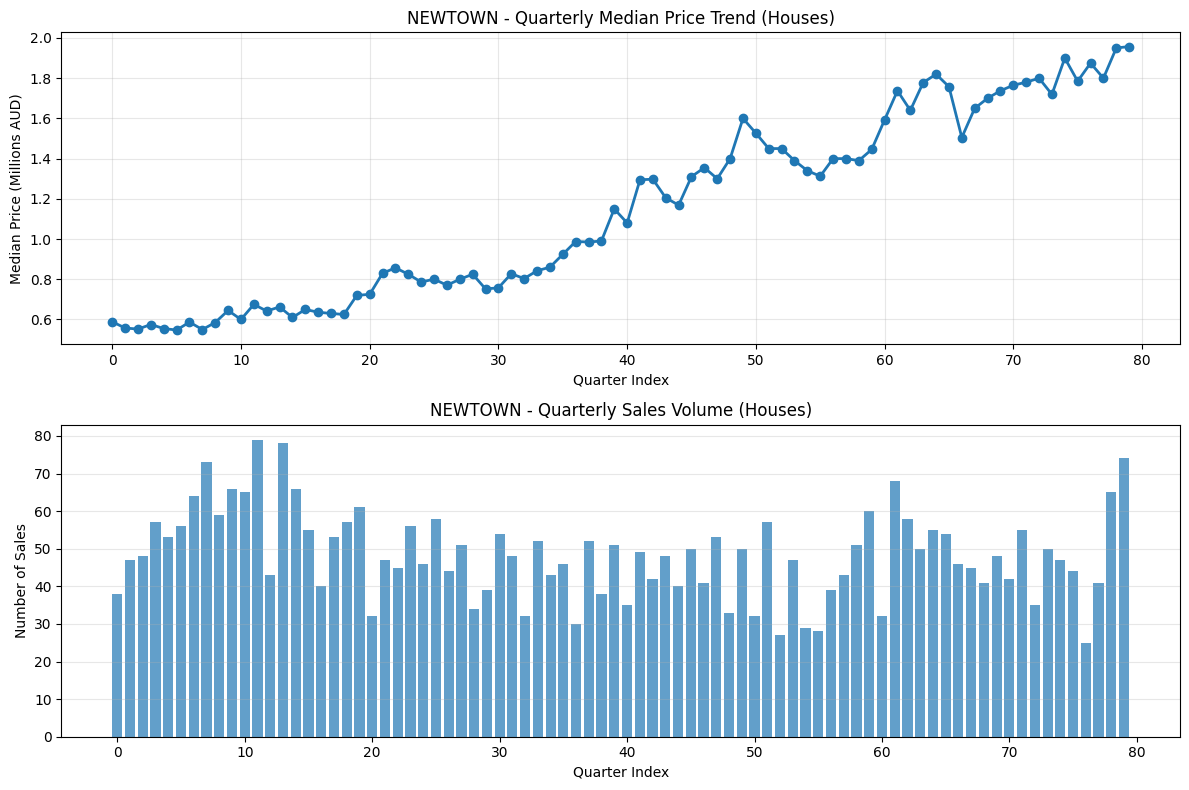

In [9]:
# Test 7: Data visualization example
print("="*80)
print("TEST 7: Data Visualization Example")
print("="*80)

# Get quarterly stats for a suburb and visualize
suburb_name = "NEWTOWN"
quarterly_data = test_endpoint("GET", f"/api/quarterly/{suburb_name}", {"property_type": "house"})

if quarterly_data:
    # Convert to DataFrame for visualization
    df = pd.DataFrame(quarterly_data)
    
    if len(df) > 0:
        # Sort by year and quarter
        df = df.sort_values(['year', 'quarter'])
        df['quarter_label'] = df['year'].astype(str) + 'Q' + df['quarter'].astype(str)
        
        print(f"\nQuarterly price trend for {suburb_name} (Houses):")
        print(f"  Date range: {df['year'].min()}Q{df[df['year']==df['year'].min()]['quarter'].min()} to {df['year'].max()}Q{df[df['year']==df['year'].max()]['quarter'].max()}")
        print(f"  Total quarters: {len(df)}")
        print(f"\nRecent quarters:")
        print(df[['quarter_label', 'median_price', 'num_sales']].tail(10).to_string(index=False))
        
        # Simple visualization
        try:
            import matplotlib.pyplot as plt
            
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
            
            # Price trend
            ax1.plot(range(len(df)), df['median_price'] / 1e6, marker='o', linewidth=2)
            ax1.set_title(f'{suburb_name} - Quarterly Median Price Trend (Houses)')
            ax1.set_xlabel('Quarter Index')
            ax1.set_ylabel('Median Price (Millions AUD)')
            ax1.grid(alpha=0.3)
            
            # Sales volume
            ax2.bar(range(len(df)), df['num_sales'], alpha=0.7)
            ax2.set_title(f'{suburb_name} - Quarterly Sales Volume (Houses)')
            ax2.set_xlabel('Quarter Index')
            ax2.set_ylabel('Number of Sales')
            ax2.grid(axis='y', alpha=0.3)
            
            plt.tight_layout()
            plt.show()
        except ImportError:
            print("Matplotlib not available for visualization")


In [10]:
# Summary
print("="*80)
print("TEST SUMMARY")
print("="*80)
print("\nSUCCESS: All API endpoints tested!")
print("\nTo start the server, run:")
print("  uvicorn src.main:app --reload")
print("\nAPI Documentation available at:")
print(f"  {BASE_URL}/docs")
print(f"  {BASE_URL}/redoc")


TEST SUMMARY

SUCCESS: All API endpoints tested!

To start the server, run:
  uvicorn src.main:app --reload

API Documentation available at:
  http://localhost:8000/docs
  http://localhost:8000/redoc
